# **Introduction to Quantum Computing (Lab 10 — Quantum ML)**

In this lab you will create some quantum machine learning models and run them on the Quokka.

In [ ]:
# the usual imports
import numpy as np
import scipy as sp
import requests
import math
import json
import sympy

from google.colab import files

# current Quokka address:
req_str_qasm = 'http://quokka1.quokkacomputing.com/qsim/qasm'

# Hello, Quantum learner!

Let's start by teaching a quantum circuit to output the number 1. Thrilling!

Below is a function that creates a circuit with a single rotation parameter and then measures.

In [ ]:
def qubit_learner(angle, count = 1000):
  qasm = '''
  OPENQASM 2.0;
  include "qelib1.inc";
  qreg q[1];
  creg result[1];
  rx({}) q[0];
  measure q[0] -> result[0];
  '''.format(angle[0])

  data = {'count': count,
          'script': qasm
          }

  result = requests.post(req_str_qasm, json=data)
  json_obj = json.loads(result.content)
  return np.mean(json_obj['result']['result'])

def objective_function(angle, bit = 1):
  error = bit - qubit_learner(angle)
  return np.abs(error)**2

We will use a built-in Scipy optimizer to demonstrate the model. Remember, each time the function is called, the Quokka runs a new circuit some number of times and returns the results.

In [ ]:
sp.optimize.minimize(objective_function,
                     x0 = np.random.randn(),
                     method = 'Nelder-Mead',
                     options ={'maxiter':10})

       message: Maximum number of iterations has been exceeded.
       success: False
        status: 2
           fun: 0.0
             x: [ 3.150e+00]
           nit: 10
          nfev: 20
 final_simplex: (array([[ 3.150e+00],
                       [ 3.100e+00]]), array([ 0.000e+00,  0.000e+00]))

## Quantum image classification

Let's do something a bit more substantial. Here we will train a quantum model to distinguish bars versus stripes in an image. First, we create the dataset.  

In [ ]:
def generate_binary_code(bit_length):
    bit_combinations = np.zeros((int(2**bit_length), bit_length))
    for number in range(int(2**bit_length)):
        dividend = number
        bit_index = 0
        while dividend != 0:
            bit_combinations[number, bit_index] = np.remainder(dividend, 2)
            dividend = np.floor_divide(dividend, 2)
            bit_index += 1
    return bit_combinations

def generate_data(length):
    stripes = generate_binary_code(length)
    stripes = np.repeat(stripes, length, 0)
    stripes = stripes.reshape(2 ** length, length * length)

    bars = generate_binary_code(length)
    bars = bars.reshape(2 ** length * length, 1)
    bars = np.repeat(bars, length, 1)
    bars = bars.reshape(2 ** length, length * length)

    return np.vstack((stripes[1:stripes.shape[0]-1],bars[1:bars.shape[0]-1]))

The only parameter is the size of the image. (Note that the number of qubits used is the number of pixels, so don't go overboard. More than four pixels will take a lot of time to simulate.)

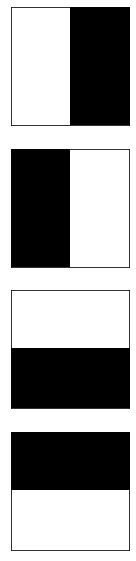

In [ ]:
length = 2
dataset = generate_data(length)
labels = np.concatenate((np.zeros(int(2**length-2)),np.ones(int(2**length-2))))
n_parameters = int(2*(length**2-1))

import matplotlib.pyplot as plt

plt.figure(figsize=[10, 10])
j = 1
for i in dataset:
    plt.subplot(4, int(2**(length-1)-1), j)
    j += 1
    plt.imshow(np.reshape(i, [length,length]), cmap="gray")
    plt.xticks([])
    plt.yticks([])

In [ ]:
# Select 75% of the entries in the array
selected_indices = np.random.choice(dataset.shape[0],
                                    int(dataset.shape[0] * 0.75),
                                    replace=False)

all_indices = np.arange(dataset.shape[0])
unselected_indices = np.setdiff1d(all_indices, selected_indices)

# Get the selected elements
training = dataset[selected_indices]
training_labels = labels[selected_indices]
test = dataset[unselected_indices]
test_labels = labels[unselected_indices]

## Creating the model

We will create a model built recursively of blocks that entangle pairs of qubits.

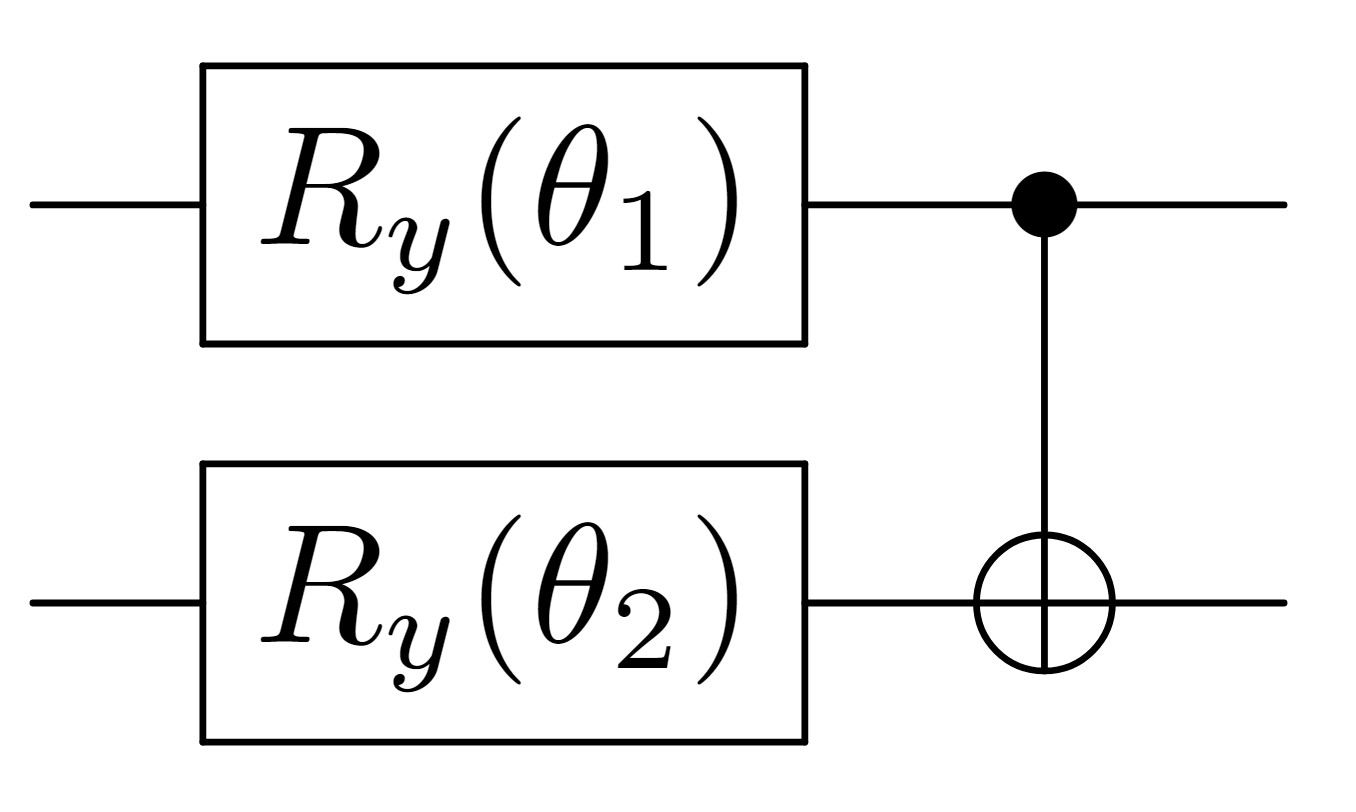

In [ ]:
def block(angles,qubits):
  qasm = '''
  ry({}) q[{}];
  ry({}) q[{}];
  cx q[{}], q[{}];
  '''.format(
      angles[0],qubits[0],
      angles[1],qubits[1],
      qubits[0],qubits[1]
  )
  return qasm

Now you will put the blocks together recursively by spliting the circuit in half successively, creating a logarithmic depth circuit. The four qubit case should look like this.

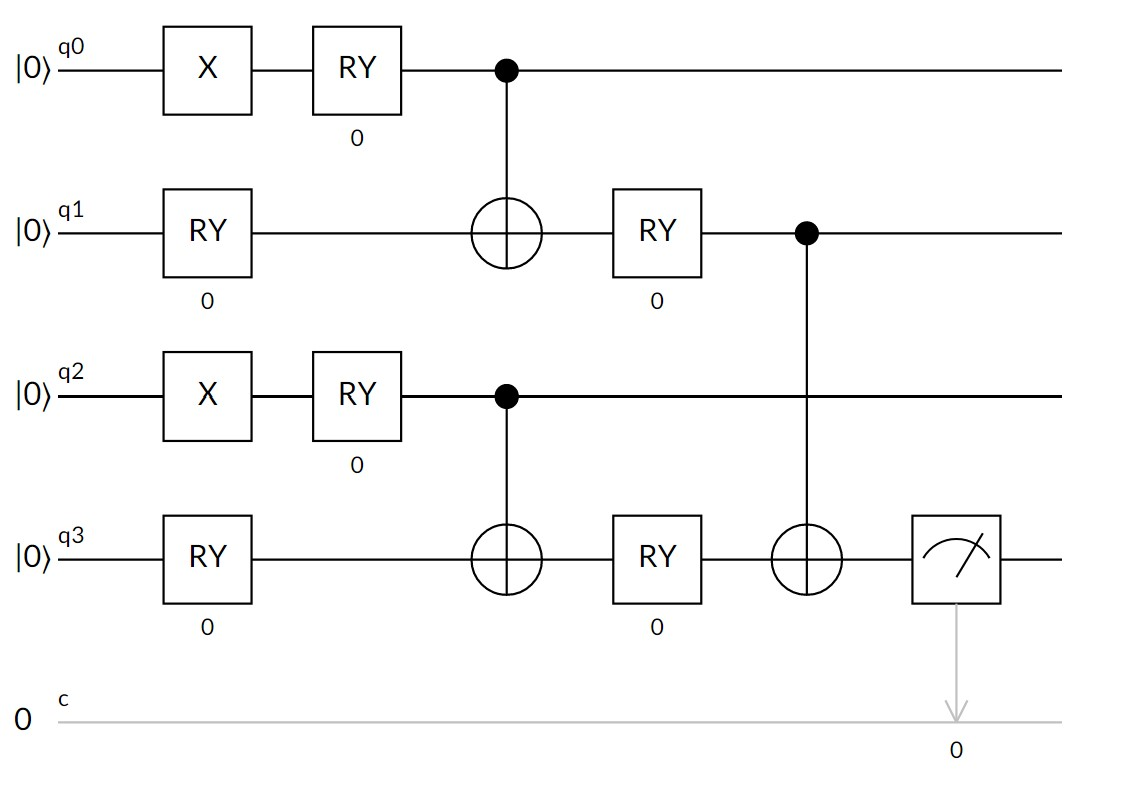

A helper function can generate all the pairs of qubits needed.

In [ ]:
def generate_pairs(mylist, start, end):
  if start == end:
      pass
  else:
    mid = (start + end - 1) // 2
    first_half = generate_pairs(mylist, start, mid)
    second_half = generate_pairs(mylist, mid + 1, end)
    mylist.append((mid,end))

In [ ]:
def create_circuit(data,angles):

  length = data.shape[0]

  qasm = '''
    OPENQASM 2.0;
    include "qelib1.inc";
    qreg q[{}];
    creg c[1];
    '''.format(length)

  for i in range(length):
    if data[i] > 0.5:
      qasm += '''
    x q[{}];
    '''.format(i)

  pairs = []
  generate_pairs(pairs,0,length-1)

  count = 0
  for (i,j) in pairs:
    qasm += block([angles[count],angles[count+1]],[i,j])
    count += 2

  qasm += '''
  measure q[{}] -> c[0];
  '''.format(length-1)

  return(qasm)

In [ ]:
# Check out an example with all zero angles.

print(create_circuit(dataset[0],np.zeros(n_parameters)))


    OPENQASM 2.0;
    include "qelib1.inc";
    qreg q[4];
    creg c[1];
    
    x q[0];
    
    x q[2];
    
  ry(0.0) q[0];
  ry(0.0) q[1];
  cx q[0], q[1];
  
  ry(0.0) q[2];
  ry(0.0) q[3];
  cx q[2], q[3];
  
  ry(0.0) q[1];
  ry(0.0) q[3];
  cx q[1], q[3];
  
  measure q[3] -> c[0];
  


## Learning!

Here you will create your objective function, which calls the Quokka, and run the classical optimizer. We'll use the same one as above for simplicity and then build our own below.

In [ ]:
def objective(x, dataset, labels, count = 10):

  n_data = dataset.shape[0]
  to_return = 0

  for idx in range(n_data):

    qasm = create_circuit(dataset[idx],x)

    data = {'count': count,
            'script': qasm
            }

    result = requests.post(req_str_qasm, json=data)
    values = json.loads(result.content)['result']['c']

    to_return += np.abs(
            np.mean(values)-labels[idx]
            )

  return to_return/n_data

In [ ]:
sol = sp.optimize.minimize(lambda x: objective(x,training,training_labels,count=int(1e2)),
                           x0 = np.pi*np.random.randn(n_parameters),
                           method = 'Nelder-Mead', options ={'maxiter':1e1})
print(sol)

       message: Maximum number of iterations has been exceeded.
       success: False
        status: 2
           fun: 0.46714285714285725
             x: [-4.959e+00  4.471e+00 ...  4.793e-01  2.956e+00]
           nit: 10
          nfev: 42
 final_simplex: (array([[-4.959e+00,  4.471e+00, ...,  4.793e-01,
                         2.956e+00],
                       [-4.983e+00,  4.492e+00, ...,  4.816e-01,
                         2.970e+00],
                       ...,
                       [-4.959e+00,  4.471e+00, ...,  4.793e-01,
                         2.956e+00],
                       [-4.959e+00,  4.471e+00, ...,  4.793e-01,
                         2.956e+00]]), array([ 4.671e-01,  4.729e-01, ...,  4.995e-01,  5.000e-01]))


## A different optimizer

The [Simultaneous Perturbation Stochastic Approximation](https://en.wikipedia.org/wiki/Simultaneous_perturbation_stochastic_approximation) (SPSA) algorithm is a popular stochastic optimization technique for solving optimization problems in a variety of applications. It was first introduced by Spall in 1992 as a variant of the stochastic approximation method.

SPSA is a gradient-free optimization algorithm, meaning that it does not require knowledge of the gradient of the objective function. Instead, it uses a series of random perturbations to estimate the gradient of the objective function at each iteration. This makes it well-suited for optimizing functions that are expensive or difficult to compute gradients for.

At each iteration, the SPSA algorithm randomly perturbs the input variables and computes the corresponding function values. It then uses these function values to estimate the gradient of the objective function, and updates the input variables using a stochastic approximation rule. This process is repeated until convergence is achieved or a stopping criterion is met.

One of the key advantages of SPSA is its simplicity and ease of implementation.

In [ ]:
def spsa(func, x0, a=0.1, c=0.01, alpha=0.602, gamma=0.101, maxiter=100, verbose=False):

    k = 0
    x = x0

    while k < maxiter:
        ak = a / (k+1)**alpha
        ck = c / (k+1)**gamma
        delta = 2 * np.random.randint(0, 2, len(x0)) - 1
        xp = x + ck * delta
        xm = x - ck * delta
        grad = (func(xp) - func(xm)) / (2 * ck) * delta

        x = x - ak * grad

        # Print progress message
        if verbose and k % int(0.1*maxiter) == 0:
            fx = func(x)
            print(f"Iteration {k}: f = {fx}")

        k += 1

    return x

In [ ]:
f = lambda x: objective(x,training,training_labels,count=int(1e2))
x0 = np.pi*np.random.randn(n_parameters)

a = 1
c = 0.5
maxiter= 1e2
alpha = 0.602
gamma = 0.101

xsol = spsa(f, x0, a=a, c=c,
            alpha=alpha, gamma=gamma,
            maxiter=maxiter, verbose=True)

Iteration 0: f = 0.47250000000000003
Iteration 10: f = 0.485
Iteration 20: f = 0.4475
Iteration 30: f = 0.43000000000000005
Iteration 40: f = 0.35500000000000004
Iteration 50: f = 0.3425
Iteration 60: f = 0.27749999999999997
Iteration 70: f = 0.2425
Iteration 80: f = 0.16000000000000003
Iteration 90: f = 0.1275
